In [1]:
import pandas as pd
import numpy as np

import openpyxl
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta
from itertools import islice

In [2]:

# open excel file
excel_file = "tenancy_list_05SEP2022.xlsx"
wb = openpyxl.load_workbook(excel_file, data_only=True)

# getting all sheets
sheets = wb.sheetnames

# getting a particular sheet
sheet_params = wb["params"]
sheet_data = wb["tenant"]
sheet_rental = wb["rental"]
sheet_yearly_rental = wb["yearly_rental"]
sheet_sc = wb["sc"]
sheet_yearly_sc = wb["yearly_sc"]
sheet_total = wb["total_rev"]
sheet_occ = wb["occ_rate"]

# reading parameters
date_start = sheet_params["C4"].value
date_end = sheet_params['C5'].value
area_rentable_office = sheet_params["C6"].value
#report_sum = sheet_params["C7"].value

# generate reporting daterange based on start and end dates
my_reporting_date_range = pd.date_range(start=date_start, end=date_end, freq='MS')


In [3]:
data = sheet_data.values
cols = next(data)[1:]
data = list(data)
#idx = [r[0] for r in data]
data = (islice(r, 1, None) for r in data)
df_data = pd.DataFrame(data, columns=cols)

# drop rows where column Tenant is Null/NA
df_data = df_data[df_data['Tenant'].notna()]

In [4]:
report_sum = 'M'

# Create report dataframe using datetime index for period
df_report_rental_charge = pd.DataFrame(my_reporting_date_range, columns=['date'])   # Rental revenue
df_report_sc_charge = pd.DataFrame(my_reporting_date_range, columns=['date'])       # Service charge revenue
df_report_sc_charge_rate = pd.DataFrame(my_reporting_date_range, columns=['date'])       # Service charge rate
df_report_occupancy = pd.DataFrame(my_reporting_date_range, columns=['date'])       # Occupancy rate

# Set 'date' as the index
df_report_rental_charge = df_report_rental_charge.set_index('date')
df_report_sc_charge = df_report_sc_charge.set_index('date')
df_report_sc_charge_rate = df_report_sc_charge_rate.set_index('date')
df_report_occupancy = df_report_occupancy.set_index('date')

# Calculate how much is SC rate based on months and years
# April 2022: 75000
# April 2024: 80000
# April 2026: 85000

sc_data = [
    [datetime(2018, 4, 1), 65000.00],
    [datetime(2020, 4, 1), 70000.00],
    [datetime(2022, 4, 1), 70000.00],
    [datetime(2024, 4, 1), 75000.00],
    [datetime(2027, 4, 1), 80000.00],
    [datetime(2030, 4, 1), 85000.00],
    [datetime(2033, 4, 1), 90000.00],
]

# select rows according to product_type
options = ['Office']
df_by_product = df_data[df_data['Product_Type'].isin(options)]

substring = '-'
for index, row in df_by_product.iterrows():
    vacant = False

    data_area = row['Area']
    data_rental_rate = row['Rental_Rate']
    data_sc_rate = row['SC_Rate']

    if (data_area == None) or (substring in str(data_area)):
        data_area = 0.0

    if (data_rental_rate == None) or (substring in str(data_rental_rate)):
        data_rental_rate = 0.0

    if (data_sc_rate == None) or (substring in str(data_sc_rate)):
        data_sc_rate = 0.0


    start = row["Start"]
    end = row["End"]

    if (pd.isna(end)) or (end == '-'):
        vacant = True
        end = date_end

    if not vacant:
        if (pd.isna(start)) or (start == '-'):
            start = date_start

        str_level = str(row['Floor']).split('.')[0]
        str_zone = str(row['Zone'])

        if (str_level == 'None'):
            str_level = 'NA'
        if (str_zone == 'None'):
            str_zone = 'NA'

        # join them
        str_sep = '-'
        str_temps = [str(str_level), str(str_zone), str(index)]
        str_column_name = str_sep.join(str_temps)

        tenant_date_range = pd.date_range(start=start, end=end, freq='MS')

        # calculate monthly rental
        calc_rental_charge = data_area * data_rental_rate

        # generate rental charge
        df_tenant_rental_charge = pd.DataFrame(tenant_date_range, columns=['date']) # create new df with only 1 column called 'date' and fill with the date range from lcd to led
        df_tenant_rental_charge = df_tenant_rental_charge.set_index('date') # set 'date' as the index
        df_tenant_rental_charge[str_column_name] = calc_rental_charge # add a new column called <num> and fill all with the rental_charge value
        df_report_rental_charge = df_report_rental_charge.join(df_tenant_rental_charge, how="left")

        # generate service charge report
        # df_sc_data = pd.DataFrame(data=sc_data, columns=['date', 'sc']).set_index('date')
        df_sc_data = pd.DataFrame(data=sc_data, columns=['date', 'sc'])
        df_sc_data.reset_index(inplace=True)
        sc_date_range = pd.date_range(start=df_sc_data.date.values.min(), end=df_sc_data.date.values.max(), freq='D')
        df_sc = pd.DataFrame(sc_date_range, columns=['date'])
        df_sc = df_sc.set_index('date')

        # data_sc_rate = 70000
        # str_column_name = 'TEST'

        length = len(df_sc_data.index)
        for i in range(length):
            if i < length-1:
                date1 = df_sc_data.iloc[i,1]
                date2 = df_sc_data.iloc[i+1,1]
                sc_rate = df_sc_data.iloc[i,2]
                print(f"{date1} to {date2} is {sc_rate}" )
                if data_sc_rate == 0:
                    df_sc.loc[date1.strftime('%Y-%m-%d'):date2.strftime('%Y-%m-%d'), str_column_name] = 0
                elif data_sc_rate == 84100:
                    df_sc.loc[date1.strftime('%Y-%m-%d'):date2.strftime('%Y-%m-%d'), str_column_name] = 84100
                else:
                    df_sc.loc[date1.strftime('%Y-%m-%d'):date2.strftime('%Y-%m-%d'), str_column_name] = df_sc_data.loc[i, 'sc']


        df_sc_rate_temp = df_sc
        df_sc = df_sc * data_area
        tenant_date_range = pd.date_range(start=start, end=end, freq='MS')

        df_tenant_service_charge = pd.DataFrame(tenant_date_range, columns=['date'])
        df_tenant_service_charge = df_tenant_service_charge.set_index('date')
        df_tenant_service_charge = df_tenant_service_charge.join(df_sc, how='left')
        df_report_sc_charge = df_report_sc_charge.join(df_tenant_service_charge, how="left")

        df_tenant_service_charge_rate = pd.DataFrame(tenant_date_range, columns=['date'])
        df_tenant_service_charge_rate = df_tenant_service_charge_rate.set_index('date')
        df_tenant_service_charge_rate = df_tenant_service_charge_rate.join(df_sc_rate_temp, how='left')
        df_report_sc_charge_rate = df_report_sc_charge_rate.join(df_tenant_service_charge_rate, how="left")


        # generate occupancy report
        df_tenant_occupancy = pd.DataFrame(tenant_date_range, columns=['date'])
        df_tenant_occupancy = df_tenant_occupancy.set_index('date')
        df_tenant_occupancy[str_column_name] = data_area
        df_report_occupancy = df_report_occupancy.join(df_tenant_occupancy, how="left")

# Clean dataframes
df_report_rental_charge.fillna(0, inplace=True)
df_report_sc_charge.fillna(0, inplace=True)
df_report_occupancy.fillna(0, inplace=True)

# sum each rows
df_report_rental_charge['sum'] = df_report_rental_charge.sum(axis=1)
df_report_sc_charge['sum'] = df_report_sc_charge.sum(axis=1)
df_report_occupancy['sum'] = df_report_occupancy.sum(axis=1)

# create summary report
df_sum = pd.DataFrame()
df_sum['Rental'] = df_report_rental_charge.resample(report_sum).sum()['sum']
df_sum['SC'] = df_report_sc_charge.resample(report_sum).sum()['sum']
df_sum['Total'] = df_sum.sum(axis=1)

df_sum['Occ'] = df_report_occupancy.resample(report_sum).mean()['sum']
df_sum['OccPct'] = df_sum['Occ']/area_rentable_office
df_sum.reset_index(inplace=True)


2018-04-01 00:00:00 to 2020-04-01 00:00:00 is 65000.0
2020-04-01 00:00:00 to 2022-04-01 00:00:00 is 70000.0
2022-04-01 00:00:00 to 2024-04-01 00:00:00 is 70000.0
2024-04-01 00:00:00 to 2027-04-01 00:00:00 is 75000.0
2027-04-01 00:00:00 to 2030-04-01 00:00:00 is 80000.0
2030-04-01 00:00:00 to 2033-04-01 00:00:00 is 85000.0
2018-04-01 00:00:00 to 2020-04-01 00:00:00 is 65000.0
2020-04-01 00:00:00 to 2022-04-01 00:00:00 is 70000.0
2022-04-01 00:00:00 to 2024-04-01 00:00:00 is 70000.0
2024-04-01 00:00:00 to 2027-04-01 00:00:00 is 75000.0
2027-04-01 00:00:00 to 2030-04-01 00:00:00 is 80000.0
2030-04-01 00:00:00 to 2033-04-01 00:00:00 is 85000.0
2018-04-01 00:00:00 to 2020-04-01 00:00:00 is 65000.0
2020-04-01 00:00:00 to 2022-04-01 00:00:00 is 70000.0
2022-04-01 00:00:00 to 2024-04-01 00:00:00 is 70000.0
2024-04-01 00:00:00 to 2027-04-01 00:00:00 is 75000.0
2027-04-01 00:00:00 to 2030-04-01 00:00:00 is 80000.0
2030-04-01 00:00:00 to 2033-04-01 00:00:00 is 85000.0
2018-04-01 00:00:00 to 2020-

In [11]:
df = df_report_sc_charge.drop(['sum'], axis = 1)
df.mask(df > 0, 1, inplace =True)
df

,PH-All-0,55-All-1,53-All-2,52-All-3,51-C-4,"51-A,B,D,E,F-5",50-All-6,39-All-7,38-All-8,37-All-9,...,5-All-114,5-All-115,3-All-116,1-All-117,1-All-118,1-All-119,1-All-120,1-All-121,1-All-122,1-All-123
date,,,,,,,,,,,,,,,,,,,,,
2022-01-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2022-02-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2022-03-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2022-04-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2022-05-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032-08-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2032-09-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2032-10-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


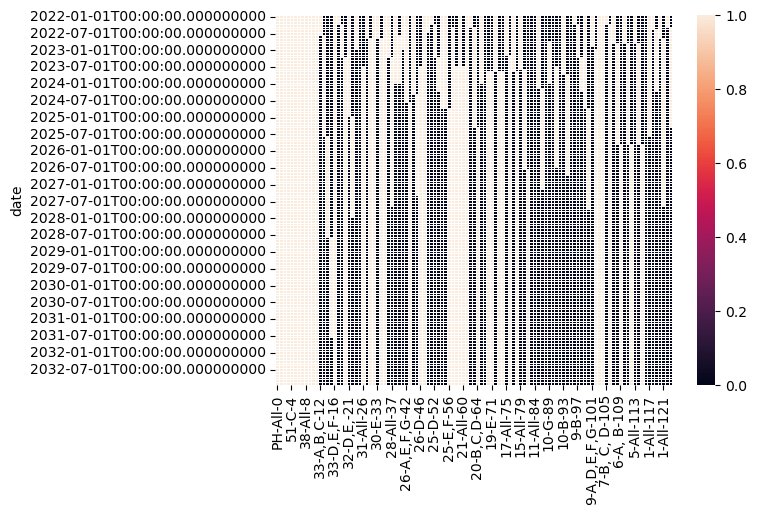

In [12]:
import numpy as np
import seaborn as sns

df = df_report_sc_charge.drop(['sum'], axis = 1)
df.mask(df > 0, 1, inplace =True)

ax = sns.heatmap(df, linewidth =.5)

In [41]:
import numpy as np
import plotly.express as px

df = df_report_occupancy.drop(['sum'], axis = 1)
df.mask(df > 0, 1, inplace =True)

fig = px.imshow(df.loc['2023'].iloc[:,:], color_continuous_scale="gray")
fig.update_traces(xgap = 1, ygap = 1)
fig.show()

In [32]:
df.loc['2022'].iloc[:,0:10]

,PH-All-0,55-All-1,53-All-2,52-All-3,51-C-4,"51-A,B,D,E,F-5",50-All-6,39-All-7,38-All-8,37-All-9
date,,,,,,,,,,
2022-01-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2022-02-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2022-03-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2022-04-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2022-05-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2022-06-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2022-07-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2022-08-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2022-09-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
import pandas as pd
import numpy as np

import openpyxl
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta
from itertools import islice

In [ ]:
sc_data = [
    [datetime(2018, 4, 1), 65000.00],
    [datetime(2020, 4, 1), 70000.00],
    [datetime(2022, 4, 1), 70000.00],
    [datetime(2024, 4, 1), 75000.00],
    [datetime(2027, 4, 1), 80000.00],
    [datetime(2030, 4, 1), 85000.00],
    [datetime(2033, 4, 1), 90000.00],
]

df_sc_data = pd.DataFrame(data=sc_data, columns=['date', 'sc'])
df_sc_data.reset_index(inplace=True)
sc_date_range = pd.date_range(start=df_sc_data.date.values.min(), end=df_sc_data.date.values.max(), freq='M')
df_sc = pd.DataFrame(sc_date_range, columns=['date'])
df_sc = df_sc.set_index('date')

data_sc_rate = 70000
str_column_name = 'TEST'

length = len(df_sc_data.index)
for i in range(length):
    if i < length-1:
        date1 = df_sc_data.iloc[i,1]
        date2 = df_sc_data.iloc[i+1,1]
        sc_rate = df_sc_data.iloc[i,2]
        print(f"{date1} to {date2} is {sc_rate}" )
        if data_sc_rate == 0:
            df_sc.loc[date1.strftime('%Y-%m-%d'):date2.strftime('%Y-%m-%d'), str_column_name] = 0
        elif data_sc_rate == 84100:
            df_sc.loc[date1.strftime('%Y-%m-%d'):date2.strftime('%Y-%m-%d'), str_column_name] = 84100
        else:
            df_sc.loc[date1.strftime('%Y-%m-%d'):date2.strftime('%Y-%m-%d'), str_column_name] = df_sc_data.loc[i, 'sc']



In [ ]:
i